In [1]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection

In [6]:
data = pandas.read_csv(os.path.join('..', 'data', 'kao_data.csv'))
data.diagnosis.replace({'disease':1, 'normal':0}, inplace=True)
data.columns = data.columns.str.replace("[() ,-]", "_")
data.head()

,pidn,gender,birthday,case_date,age,diagnosis,stage_I_IIboth,stageIII_IVboth,stage_5_6both,Frontal_lobeboth,...,PutamenL,PutamenR,PallidumL,PallidumR,HippocampusL,HippocampusR,AmygdalaL,AmygdalaR,AccumbensL,AccumbensR
0,118,1,1959-05-24,2020-05-06,60.994521,1,1.186645,0.986664,0.915227,0.865232,...,1.025486,1.047465,1.144742,1.117940,1.232588,1.322048,1.060368,1.004850,0.927153,0.906127
1,635,0,1947-02-21,2021-09-04,74.586301,1,1.486503,1.673842,1.317035,1.363883,...,1.413219,1.438028,1.164178,1.277366,1.401264,1.513620,1.457985,1.549947,1.604411,1.589300
2,1247,1,1949-07-13,2021-07-23,85.802740,1,0.863529,1.092497,0.980145,0.856609,...,1.034929,0.996200,1.094785,1.121078,0.906051,0.815060,0.866736,0.813185,0.877843,0.933986
3,1274,1,1939-05-19,2021-04-16,78.101370,1,0.917792,1.150944,1.068748,1.029668,...,1.613651,1.602802,1.541347,1.476991,0.863824,0.868055,1.031739,1.030657,1.177117,1.204226
4,1407,1,1935-08-06,2021-04-16,65.753425,1,0.836405,0.949417,0.945565,0.915934,...,1.254035,1.219716,1.246334,1.309690,0.820325,0.841339,0.752240,0.735306,0.645981,0.905331


In [7]:
biomarkers = list(data.drop(['pidn', 'gender', 'birthday', 'case_date', 'age', 'diagnosis'], axis=1).columns)

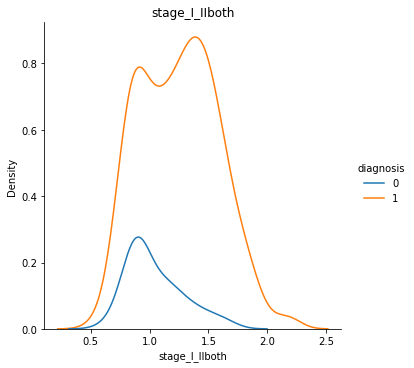

In [8]:
biomarker = biomarkers[0]
sns.displot(data=data, # our dataframe
            x=biomarker, # name of the the distribution we want to plot
            hue='diagnosis', # the "grouping" variable
            kind='kde') # kind can also be 'hist' or 'ecdf'
plt.title(biomarker)
plt.show()

<AxesSubplot:xlabel='age', ylabel='Frontal_lobeboth'>

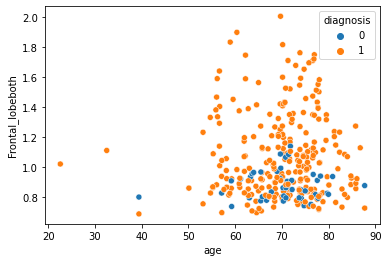

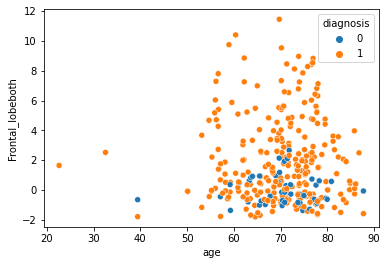

In [9]:
# now we perform the normalization

# make a copy of our dataframe (we don't want to overwrite our original data)
zdata = pandas.DataFrame(data,copy=True)

# for each biomarker
for biomarker in biomarkers:
    mod = smf.ols('%s ~ age'%biomarker,  # fit a model finding the effect of age and headsize on biomarker
                  data=data[data.diagnosis==0] # fit this model *only* to individuals in the control group
                 ).fit() # fit model    
    #print(mod.summary())
    
    # get the "predicted" values for all subjects based on the control model parameters
    predicted = mod.predict(data[['age', biomarker]]) 
    
    # calculate our zscore: observed - predicted / SD of the control group residuals
    w_score = (data.loc[:,biomarker] - predicted) / mod.resid.std()
    
    #print(np.mean(w_score[data.Diagnosis==0]))
    #print(np.std(w_score[data.Diagnosis==0]))
    
    # save zscore back into our new (copied) dataframe
    zdata.loc[:,biomarker] = w_score
    
    
plt.figure(0)
sns.scatterplot(x=data.age,y=data.Frontal_lobeboth,hue=data.diagnosis)
plt.figure(1)
sns.scatterplot(x=zdata.age,y=zdata.Frontal_lobeboth,hue=zdata.diagnosis)

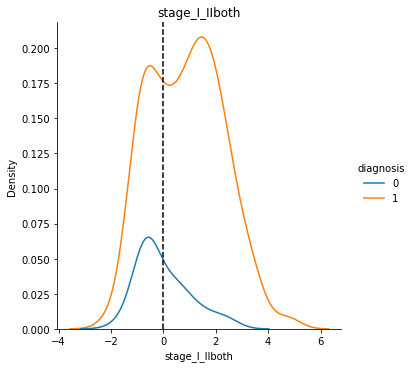

In [10]:
biomarker = biomarkers[0]
sns.displot(data=zdata,x=biomarker,hue='diagnosis',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

In [11]:
N = len(biomarkers)         # number of biomarkers

SuStaInLabels = biomarkers
Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)           # maximum z-score

In [12]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 25
N_S_max = 5
N_iterations_MCMC = int(1e5)
output_folder = os.path.join(os.getcwd(), 'KaoOutput_all')
dataset_name = 'KaoOutput_all'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              zdata[biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

In [13]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [ ]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: D:\Projects\d2is\pySustain\KaoOutput_all\pickle_files\KaoOutput_all_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem


In [ ]:
# for each subtype model
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s+1))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s+1))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')


In [ ]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 4 # 1 split = 2 subtypes
M = len(zdata) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,
                                                samples_sequence,
                                                samples_f,
                                                M,
                                                figsize=(50, 25),
                                                title_font_size=30, 
                                                stage_font_size=20,
                                                label_font_size=30)